In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2 as cv
import os
from pathlib import Path

In [2]:
print(f"OpenCV Version: {cv.__version__}")

OpenCV Version: 4.8.0


In [3]:
parasitized_path = Path('cell_images/Parasitized/')
uninfected_path = Path('cell_images/Uninfected/')

print(f"Parasitized Images Path: {parasitized_path}")
print(f"Uninfected Images Path: {uninfected_path}")

Parasitized Images Path: cell_images\Parasitized
Uninfected Images Path: cell_images\Uninfected


Number of Parasitized Images: 13780
Number of Uninfected Images: 13780


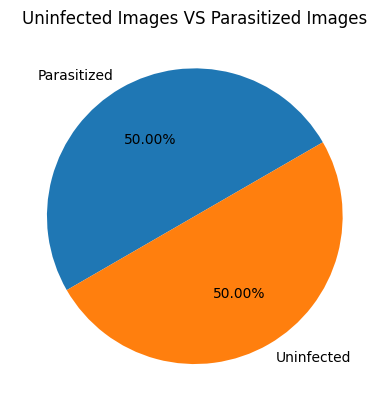

In [4]:
no_parasitized_images = len(os.listdir(parasitized_path))
no_uninfected_images = len(os.listdir(uninfected_path))

print(f"Number of Parasitized Images: {no_parasitized_images}")
print(f"Number of Uninfected Images: {no_uninfected_images}")

number_of_images = {"Parasitized":no_parasitized_images , "Uninfected":no_uninfected_images}

plt.title('Uninfected Images VS Parasitized Images')
plt.pie(number_of_images.values() , labels=number_of_images.keys() ,autopct='%1.2f%%', startangle=30)
plt.show();

<br/>
<br/>

# VISUALIZING THE DATA

In [5]:
from random import randint

def get_indices(NUMBER_OF_IMAGES):
    uninfected_indices = []
    parasitized_indices = []

    for i in range(NUMBER_OF_IMAGES):
        uninfected_indices.append(randint(0,no_uninfected_images))
        parasitized_indices.append(randint(0,no_parasitized_images))

    return uninfected_indices,parasitized_indices

In [6]:
def plot_images(NUMBER_OF_IMAGES):
    
    uninfected_indices,parasitized_indices = get_indices(NUMBER_OF_IMAGES)

    plt.figure(figsize=(20,20))
    fig,ax = plt.subplots(nrows=len(uninfected_indices) , ncols=2 )

    for i in range(len(uninfected_indices)):
        
        uninfected_image_name = os.listdir(uninfected_path)[uninfected_indices[i]]
        uninfected_image = cv.imread(f"./cell_images/Uninfected/{uninfected_image_name}")

        parasitized_image_name = os.listdir(parasitized_path)[parasitized_indices[i]]
        parasitized_image = cv.imread(f"./cell_images/Parasitized/{parasitized_image_name}")

        ax[i][0].imshow(uninfected_image)
        ax[i][1].imshow(parasitized_image)

        ax[i][0].axis(False)
        
        ax[i][1].axis(False)

    ax[0][0].set_title('UnInfected')
    ax[0][1].set_title('Parasitized')
    plt.show();

<Figure size 2000x2000 with 0 Axes>

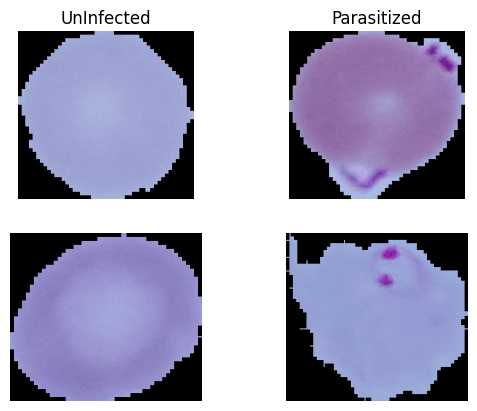

In [7]:
NUMBER_OF_IMAGES = 2
plot_images(NUMBER_OF_IMAGES)

<br/>
<br/>
<br/>

# DIVIDING TO TRAIN , TEST AND VALIDATION DATA

In [8]:
import math
import shutil

TRAIN_RATIO = 0.6
VALIDATION_RATIO = 0.12

total_images = no_parasitized_images + no_uninfected_images
train_images = math.floor(TRAIN_RATIO*total_images)
validation_images = math.floor(VALIDATION_RATIO*total_images)

print(f"TOTAL IMAGES: {total_images}")
print(f"TRAIN IMAGES: {train_images}")
print(f"VALIDATION IMAGES: {validation_images}")
print(f"TEST IMAGES: {total_images-train_images-validation_images}")

TOTAL IMAGES: 27560
TRAIN IMAGES: 16536
VALIDATION IMAGES: 3307
TEST IMAGES: 7717


In [9]:
from sklearn.model_selection import train_test_split

def split_data(TRAIN_RATIO , VALIDATION_RATIO):

    # Importing all the images in a numpy array and giving the image label as parasitized or uninfected
    images_array = np.array(os.listdir('./cell_images/Parasitized/'))
    labels_array = np.array(['Parasitized']*len(images_array))

    images_array = np.hstack([images_array , os.listdir('./cell_images/Uninfected/')])
    labels_array = np.hstack([labels_array , np.array( ['Uninfected'] * (len(images_array)-len(labels_array)) )] )     
    
    # Creating a DataFrame and shuffling it
    df = pd.DataFrame( {"images":images_array , "labels":labels_array } )
    df['images'] = df['images'].astype('string')
    df = df[df['images'].str.endswith('.png')][['images','labels']]
    
    # Splitting by sklearn train_test_split
    X = df['images']
    y = df['labels']

    new_test_ratio = 1 - ( VALIDATION_RATIO / (1-TRAIN_RATIO) ) 
    train_images , test_images , train_labels , test_labels = train_test_split( X , y , train_size=TRAIN_RATIO , random_state=42 , stratify=y) 
    val_images , test_images , val_labels , test_labels = train_test_split( test_images , test_labels , test_size=new_test_ratio , random_state=42 , stratify=test_labels) 

    
    split_data_dict  = {"train":{"train_images":train_images , "train_labels":train_labels} , "test":{"test_images":test_images,"test_labels":test_labels} , "val":{"val_images":val_images , "val_labels":val_labels}}
    return split_data_dict

In [10]:
def plot_data_ratio(split_data_dict):
    
    plt.figure(figsize=(30,30))
    fig,ax = plt.subplots(nrows=1 , ncols=3 )
    
    train_labels_count = split_data_dict["train"]["train_labels"].value_counts()
    ax[0].pie(train_labels_count.values , labels=train_labels_count.index ,autopct='%1.2f%%', startangle=30)
    ax[0].set_title('Train Labels Count')
    
    val_labels_count = split_data_dict["val"]["val_labels"].value_counts()
    ax[1].pie(val_labels_count.values , labels=val_labels_count.index ,autopct='%1.2f%%', startangle=30)
    ax[1].set_title('Val Labels Count')
    
    test_labels_count = split_data_dict["test"]["test_labels"].value_counts()
    ax[2].pie(test_labels_count.values , labels=test_labels_count.index ,autopct='%1.2f%%', startangle=30)
    ax[2].set_title('Test Labels Count')

    plt.show();

In [11]:
def copy_data(split_data_dict:dict):
    
    # Creating a directory of name data and if it exists then deleting it and creating it again
    data_dir_path = f"{os.getcwd()}{os.sep}data"
    if('data' in os.listdir()):
       shutil.rmtree(data_dir_path)
    os.mkdir(data_dir_path)

    
    keys = split_data_dict.keys()
    
    for key in keys:    
        images = split_data_dict[key][f"{key}_images"]
        labels = split_data_dict[key][f"{key}_labels"]
        os.mkdir(f"{data_dir_path}{os.sep}{key}")

        for index in images.index:
            
            if(labels[index]=="Parasitized"):
                img_path = f".{os.sep}cell_images{os.sep}Parasitized{os.sep}{images[index]}"
            else:
                img_path = f".{os.sep}cell_images{os.sep}Uninfected{os.sep}{images[index]}"

            new_img_path = f".{os.sep}data{os.sep}{key}{os.sep}{images[index]}"
            shutil.copyfile(img_path,new_img_path)
            
            # renameing the file to include label in the filename
            
            if labels[index]=="Parasitized" : new_file_name = f".{os.sep}data{os.sep}{key}{os.sep}1_{images[index]}"
            else : new_file_name = f".{os.sep}data{os.sep}{key}{os.sep}0_{images[index]}"

            os.rename(new_img_path,new_file_name)

        print(f"{key.upper()} DATA COPIED SUCCESSFULLY !!!")

<Figure size 3000x3000 with 0 Axes>

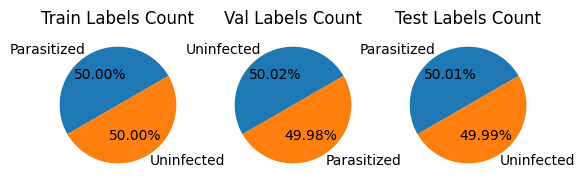

TRAIN DATA COPIED SUCCESSFULLY !!!
TEST DATA COPIED SUCCESSFULLY !!!
VAL DATA COPIED SUCCESSFULLY !!!


In [12]:
if('data' not in os.listdir()):
    split_data_dict = split_data(TRAIN_RATIO,VALIDATION_RATIO)
    plot_data_ratio(split_data_dict)
    copy_data(split_data_dict)